In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import pickle as pickle
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.linalg import norm
from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import cosine

# Introduction:
Suggesting the right beer for someone is always an intellectually difficult affair. It is, frankly, impossible to stay objective in the process. So when emotion dominates our decisions, it may be better to delegate the decision making to a recommender system. Especially given that recommender system may likely have a deeper pool to make recomendations from thanks to the fine folks at BeerAdvocates making their review data public.

## Goal:
To produce a recommender system that can predict the score of beers for a user based on their review history.

## Data Sources:
This project will rely on two sources of data, the first a set of over 1.5 million reviews, the second a data set attempting to provide numeric measures of various beer qualitites with Natural Language Processing approach to deciphering beer reviews.
The combination of these two will produce the ability to find similarities between beers, and similarities between beer drinkers.

## Inspiration / Jumping Off Point:
A notebook produced by user ruthgn on Kaggle proved inspirational for the idea that these two data sets could be merged. It should be noted that ruthgn also turned the data into a recommender system so I've purposely avoided drawing inspiration from their recommender system. I have however looked at their data cleaning and exploration methods to gain some additional insight into the data. Some of it I agree with, some I disagree. So it will be interesting if our recommender systems produce similar results.

## Proposed Program Structure:
1. Exploratory Data Analysis
2. Create Data Set Conjunction
3. Create Recommender System Framework
4. Train Recommender System
5. Test Recommender System

# Exploratory Data Analysis

In [2]:
#Note the data was too large to upload to github, so I've included a link below to download the data locally
#https://www.kaggle.com/datasets/rdoume/beerreviews
#https://www.kaggle.com/datasets/stephenpolozoff/top-beer-information


Beer_ratings = pd.read_csv("Data\\beer_reviews.csv")
Beer_qualities = pd.read_csv("Data\\beer_data_set.csv")

In [3]:
Beer_ratings.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [4]:
Beer_ratings.shape

(1586614, 13)

<AxesSubplot:xlabel='review_overall', ylabel='Count'>

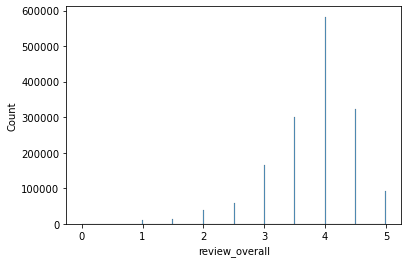

In [5]:
sns.histplot(Beer_ratings["review_overall"])

Here we can see that the ratings have an approximately normal distribution with an extended tail on the left hand side.

Before we get jazzed up about having over 1.5 million ratings to create our system from we need to work on how to check that our ratings data are rating beers that we have information about. It appears that the combination of Brewery name and beer name might be a good cross data set indicator for matching rows of the two data frames.

In [6]:
Beer_qualities.head()

,Name,key,Style,Style Key,Brewery,Description,ABV,Ave Rating,Min IBU,Max IBU,...,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty
0,Amber,251,Altbier,8,Alaskan Brewing Co.,"Notes:Richly malty and long on the palate, wit...",5.3,3.65,25,50,...,32,9,47,74,33,0,33,57,8,111
1,Double Bag,252,Altbier,8,Long Trail Brewing Co.,"Notes:This malty, full-bodied double alt is al...",7.2,3.90,25,50,...,57,18,33,55,16,0,24,35,12,84
2,Long Trail Ale,253,Altbier,8,Long Trail Brewing Co.,Notes:Long Trail Ale is a full-bodied amber al...,5.0,3.58,25,50,...,37,6,42,43,11,0,10,54,4,62
3,Doppelsticke,254,Altbier,8,Uerige Obergärige Hausbrauerei,Notes:,8.5,4.15,25,50,...,55,31,47,101,18,1,49,40,16,119
4,Scurry,255,Altbier,8,Off Color Brewing,Notes:Just cause it's dark and German doesn't ...,5.3,3.67,25,50,...,69,10,63,120,14,0,19,36,15,218


Again we have the name of a beer coupled with the brewery that produced it.

In [7]:
# Combine the Brewery name and beer name in the reviews data frame, and in the beer qualities data frame.
# Then see how many reviews are for beers we can positively identify in the qualities Data Frame

# <brewery_name>_<beer_name>
# all in lower case
Beer_ratings["brewery_name"] = Beer_ratings["brewery_name"].str.lower()
Beer_ratings["beer_name"] = Beer_ratings["beer_name"].str.lower()
Beer_ratings["combined_name"] = Beer_ratings["brewery_name"] + "_" + Beer_ratings["beer_name"]
Beer_ratings["combined_name"] = Beer_ratings["combined_name"].astype("string")

#Add Code about checking for NA
Beer_ratings.dropna(axis=0, subset=['combined_name'], inplace = True)


In [8]:
Beer_ratings.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,combined_name
0,10325,vecchio birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,sausa weizen,5.0,47986,vecchio birraio_sausa weizen
1,10325,vecchio birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,red moon,6.2,48213,vecchio birraio_red moon
2,10325,vecchio birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,black horse black beer,6.5,48215,vecchio birraio_black horse black beer
3,10325,vecchio birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,sausa pils,5.0,47969,vecchio birraio_sausa pils
4,1075,caldera brewing company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,cauldron dipa,7.7,64883,caldera brewing company_cauldron dipa


In [9]:
Beer_qualities["Name"] = Beer_qualities["Name"].str.lower()
Beer_qualities["Brewery"] = Beer_qualities["Brewery"].str.lower()
Beer_qualities["combined_name"] = Beer_qualities["Brewery"] + "_" + Beer_qualities["Name"]
Beer_qualities["combined_name"] = Beer_qualities["combined_name"].astype("string")

#Add code for checking for NA
Beer_qualities.dropna(axis=0, subset=['combined_name'], inplace = True)


# Creating Data Set Conjunction

In [10]:
Beer_Ratings_Names = list(Beer_ratings["combined_name"])
Beer_Qualities_Names = list(Beer_qualities["combined_name"])

In [11]:
#This cell takes a while to run 1.5 million ratings searching through 3500+ Beer quality names
#beer_found_inequalities_count = 0
#for i in range(len(Beer_Ratings_Names)):
#    if Beer_Ratings_Names[i] in Beer_Qualities_Names:
#        beer_found_inequalities_count += 1
#print(f"Out of {len(Beer_Ratings_Names)} ratings, {beer_found_inequalities_count} ratings were represented in Beer Qualities")

In [12]:
print(f"This means that approximately {round(100*381732/1586614, 4)}% of ratings can be directly accounted for")

This means that approximately 24.0595% of ratings can be directly accounted for


After some research, it appears that fuzzy string matching may be a possible avenue for improving this matching percentage. There is a library for this purpose FuzzyWuzzy, but this library is used in the string matching by the data cleaning in the notebook I drew inspiration from. Additionally the library in question uses an algorithm Levenshtein Distance that I am interested in learning for myself. So below we will implement a Levenshtein distance function and apply it ourselves here. 
This wont be the most optimized implementation but rather an opportunity to increase the learning potential of this project.

In [13]:
# The implementation of Levenshtein Distance was guided by this article:
# https://blog.paperspace.com/implementing-levenshtein-distance-word-autocomplete-autocorrect/

def Lev_Dist(string1, string2):
    distances = np.zeros((len(string1) + 1, len(string2) + 1), dtype="int")
    
    #Initialize matrix by turning column 1 and row 1 into the number of characters
    #required to construct the string from scratch
    
    for i in range(len(string1) + 1):
        distances[i][0] = i
    for j in range(len(string2) + 1):
        distances[0][j] = j
    
    # Distances are calculated in a 2x2 matrix fashion,
    # the position (2,2) is what we are calculating and
    # it if the characters in the parent strings (string1,
    # string2) are different the (2,2) position is equal to
    # the minimum value of the other 3 cells + 1.
    
    # So we are interested in the (1,2), (2,1) and (1,1)
    # positions which will be labeled, col, row, diag,
    # respectively.

    # The values need to be initialized
    row = 0
    column = 0
    diag = 0
    
    # We will loop through every position in the distances
    # matrix, calculating the distance of the (2,2) position
    # of each sub-matrix as we progress.
    
    for i in range(1, len(string1) + 1):
        for j in range(1, len(string2) + 1):
            if string1[i-1] == string2[j-1]:
                distances[i][j] = distances[i-1][j-1]
            else:
                col = distances[i - 1][j]
                row = distances[i][j - 1]
                diag = distances[i-1][j-1]
                distances[i][j] = min([row, col, diag]) + 1
    return distances[len(string1)][len(string2)]

In [14]:
print(Lev_Dist("kelm", "hello"))

3


We now have a working way to measure the distance between the keys we have constructed for both of the tables. The next step will be to identify the closest match for each of the "unmatched" ratings. However as we will demonstrate, the time to process the Levenstein distance for each possible match is very long. We will take two approaches to diminish that time:
1. We will only include beers that have at least 25 ratings
2. We will split the computation of distances into 4 sections and run them in seperate notebooks. That way the code can run in parallel.


### Timing
First we need to establish how long this process is going to take per levenstein distance we need to measure. Then we will have the ability to reduce the number of names we need to check and then split the data into as many parts as needed to run simultaneously.

In [15]:
#Checking if the combined name worked
test_rating_key = Beer_ratings.iloc[0]["combined_name"]
test_rating_key

'vecchio birraio_sausa weizen'

In [16]:
#See if the distance calculation is in the range we would expect
distances = [Lev_Dist(test_rating_key, str(x)) for x in Beer_qualities["combined_name"]]

In [17]:
min(distances)

18

In [18]:
min_index = distances.index(min(distances))
min_index

3690

In [19]:
#So we can see that the minimum distance of 18 was to the beer name below. This is obviously not the same beer with a typo
#we will need to establish an upper threshold moving forward for determining the number of changes permissible.
Beer_qualities.iloc[min_index]["combined_name"]

'shared brewing_base weight'

In [20]:
#This function takes a beer name, and the qualities table name column
#and returns the distance and name of the closest match by levenstein distance
def Lev_Dist_Qualities_Name(beer_name, qualities_names):
    min_dist = Lev_Dist(beer_name, qualities_names[0])
    index = 0
    for i in range(1, len(qualities_names)):
        if min_dist == 0:
            return(min_dist, qualities_names[i])
        dist = Lev_Dist(beer_name, qualities_names[i])
        if dist < min_dist:
            index = i
            min_dist = dist
    return(min_dist, qualities_names[index])

In [21]:
import time

In [22]:
#Here we are beginning to measure the time it will take to compute all the levenstein distances
#from this first indication it will take ~11 seconds per beer. At 1.5 million beers that will be a very very
#long time.
qual_names = list(Beer_qualities["combined_name"])
time1 = time.time()
dist_name_column = [Lev_Dist_Qualities_Name(str(x), qual_names) for x in list(Beer_ratings["combined_name"])[:2]]
time2 = time.time()
print(f"total time was {time2 - time1}")
dist_name_column

total time was 19.047500610351562


[(18, 'shared brewing_base weight'), (16, 'off color brewing_le woof')]

In [23]:
#To reduce the amount of time we will first determine how many unique names we have in the beer ratings table
#that are not in the quality names list
unique_beers = list(set(Beer_ratings["combined_name"]))

In [24]:
count_not_found = 0
for x in unique_beers:
    if x not in qual_names:
        count_not_found += 1
print(count_not_found)

63757


In [25]:
# Find the number of unique beers that have more than 25 ratings
ratings_count = {}
for beer in list(Beer_ratings["combined_name"]):
    if beer not in ratings_count:
        ratings_count[beer] = 1
    else:
        ratings_count[beer] += 1

unique_beer_over_25_ratings = set()
for beer in list(Beer_ratings["combined_name"]):
    if ratings_count[beer] >= 25:
        unique_beer_over_25_ratings.add(beer)
count_not_found = 0
count_removed = 0
unique_beer_over_25_ratings = list(unique_beer_over_25_ratings)
unique_beer_over_25_ratings_not_in_qual_names = []
unique_beer_over_25_ratings_in_qual_names = []
for x in unique_beer_over_25_ratings: 
    if x not in qual_names:
        count_not_found += 1
        unique_beer_over_25_ratings_not_in_qual_names.append(x)
    else:
        count_removed += 1
        unique_beer_over_25_ratings_in_qual_names.append(x)
print(f"count_not_found = {count_not_found}")
print(f"count_removed = {count_removed}")
print(f"Count of beers to run Lev Dist on = {len(unique_beer_over_25_ratings_not_in_qual_names)}")
print(f"Count of unique beers with matching names = {len(unique_beer_over_25_ratings_in_qual_names)}")

count_not_found = 6641
count_removed = 1403
Count of beers to run Lev Dist on = 6641
Count of unique beers with matching names = 1403


### Parallelization
The data was split into four parts to make the total run time about 8 hours. This way it could be run overnight and be ready for work in the morning. Each of the parallel sections will return a dictionary with the ratings combined names as keys and the result of calling the Lev_Dist_Qualities_Name function on the key.

In [26]:
l1_fh = open("l1", "wb")
l2_fh = open("l2", "wb")
l3_fh = open("l3", "wb")
l4_fh = open("l4", "wb")
qual_names_fh = open("qual_names", "wb")
l1 = unique_beer_over_25_ratings_not_in_qual_names[:1661]
l2 = unique_beer_over_25_ratings_not_in_qual_names[1661:(1661 + 1661)]
l3 = unique_beer_over_25_ratings_not_in_qual_names[(1661 + 1661):(1661 + 1661 + 1661)]
l4 = unique_beer_over_25_ratings_not_in_qual_names[(1661 + 1661 + 1661):]

pickle.dump(l1, l1_fh)
l1_fh.close()

pickle.dump(l2, l2_fh)
l2_fh.close()

pickle.dump(l3, l3_fh)
l3_fh.close()

pickle.dump(l4, l4_fh)
l4_fh.close()

pickle.dump(qual_names, qual_names_fh)
qual_names_fh.close()

### Recombining Parallel Data
With the parallelization run overnight, we need to load the dictionaries back into this notebook and combine them to create our possible name substitution dictionary

In [27]:
l1_finished_fh = open("l1_dict", "rb")
l2_finished_fh = open("l2_dict", "rb")
l3_finished_fh = open("l3_dict", "rb")
l4_finished_fh = open("l4_dict", "rb")

l1_dict = pickle.load(l1_finished_fh)
l2_dict = pickle.load(l2_finished_fh)
l3_dict = pickle.load(l3_finished_fh)
l4_dict = pickle.load(l4_finished_fh)

l1_finished_fh.close()
l2_finished_fh.close()
l3_finished_fh.close()
l4_finished_fh.close()

In [28]:
def combine_dicts(dicts_tuple, threshold = None):
    """
    Params:
        threshold: The maximum Levenstein distance for an entry to be considered
    
    Sort through all four dictionaries adding entries that satisfy threshold conditions to a single
    dictionary
    """
    
    compiled_dict = {}
    for lev_dict in dicts_tuple:
        for key in lev_dict:
            if threshold is not None and lev_dict[key][0] <= threshold:
                compiled_dict[key] = lev_dict[key]
            elif threshold is None:
                compiled_dict[key] = lev_dict[key]
            
    return compiled_dict

In [29]:
for i in range(1, 11):
    full_dict = combine_dicts((l1_dict, l2_dict, l3_dict, l4_dict), threshold = i)
    print(f"For a maximum Lev dist of {i} there are {len(full_dict.keys())} possible name matches")

For a maximum Lev dist of 1 there are 36 possible name matches
For a maximum Lev dist of 2 there are 62 possible name matches
For a maximum Lev dist of 3 there are 108 possible name matches
For a maximum Lev dist of 4 there are 205 possible name matches
For a maximum Lev dist of 5 there are 360 possible name matches
For a maximum Lev dist of 6 there are 571 possible name matches
For a maximum Lev dist of 7 there are 793 possible name matches
For a maximum Lev dist of 8 there are 1084 possible name matches
For a maximum Lev dist of 9 there are 1450 possible name matches
For a maximum Lev dist of 10 there are 1818 possible name matches


In [30]:
full_dict = combine_dicts((l1_dict, l2_dict, l3_dict, l4_dict), threshold = 7)

In [31]:
#We're going to have to manually sort through all of the possible matches. To limit the amount of work we have to do only
#matches within 7 changes will be considered. We are going to construct a new dictionary with the beer ratings name as the
#key and the name it should be in the beer qualities as the value.

#ratings_to_qualities_name_dict = {}

#for i in range(len(full_dict.keys())):
#    if full_dict[list(full_dict.keys())[i]][0] <= 7:
#        print(f"Ratings name = {list(full_dict.keys())[i]} : {full_dict[list(full_dict.keys())[i]][1]} = Possible Quality Match")
#        ans = ''
#        while ans != 'y' and ans != 'n':
#            ans = input()
#            if ans == 'y':
#                ratings_to_qualities_name_dict[list(full_dict.keys())[i]] = full_dict[list(full_dict.keys())[i]][1]
#            elif ans == 'n':
#                continue
#            else:
#                print("Please use yes or no to indicate the quality of the relationship")           

In [32]:
#Save dictionary final version, next cell will load the dictionary

#name_dict_fh = open('ratings_to_qualities_name_dict', 'wb')
#pickle.dump(ratings_to_qualities_name_dict, name_dict_fh)
#name_dict_fh.close()

In [33]:
name_dict_fh = open('ratings_to_qualities_name_dict', 'rb')
ratings_to_qualities_name_dict = pickle.load(name_dict_fh)
for beer in list(Beer_qualities['combined_name']):
    ratings_to_qualities_name_dict[beer] = beer

In [34]:
ratings = Beer_ratings[(Beer_ratings.combined_name.isin(ratings_to_qualities_name_dict)) | 
                       (Beer_ratings.combined_name.isin(list(Beer_qualities['combined_name'])))]

In [35]:
ratings = ratings[['combined_name', 'review_overall', 'review_profilename']]

In [36]:
print(len(ratings))

465981


<AxesSubplot:xlabel='review_overall', ylabel='Count'>

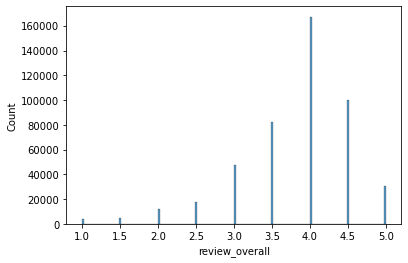

In [37]:
sns.histplot(ratings['review_overall'])

We can see that the distribution holds, even after filtering out reviews that can't be linked to the Beer_qualities data set.

## Data Preperation
1. Split ratings data into train and test
2. Create Ratings Matrix based on user id and beer names, shape is (user_id, beer_name)
3. Create beer quality matrix, shape is (beer_name, # of qualities)
4. Create Collaborative similarity matrix
5. Create Content based similarity matrix

### Split Data

In [38]:
user_names = list(set(ratings["review_profilename"]))
beer_names = list(set(Beer_qualities["combined_name"]))
test_data_size = int(len(ratings.index) * 0.2)
shuffled_ratings = ratings.sample(frac = 1, random_state = 22).reset_index(drop=True)
test_ratings = shuffled_ratings[:test_data_size]
train_ratings = shuffled_ratings[test_data_size:]
print(f"Number of training ratings = {len(train_ratings)}")
print(f"Number of test ratings = {len(test_ratings)}")

Number of training ratings = 372785
Number of test ratings = 93196


### Ratings Matrix

In [39]:
user_to_index = dict(zip(user_names, list(range(len(user_names)))))
beer_to_index = dict(zip(beer_names, list(range(len(beer_names)))))

rating_scores = train_ratings['review_overall'].astype('float')
user_index = [user_to_index[x] for x in train_ratings['review_profilename']]
beer_index = [beer_to_index[ratings_to_qualities_name_dict[x]] for x in list(train_ratings['combined_name'])]

#for i in range(len(train_ratings)):
#    print('bass brewers limited_bass pale ale' in list(train_ratings['combined_name']))
#    print(f"{i} : {train_ratings.iloc[i]}")
#    name = train_ratings.iloc[i]['combined_name']
#    print(name)
#    print(i)
#    if name not in list(Beer_qualities['combined_name']):
#        name = ratings_to_qualities_name_dict[name]
#    beer_index.append(beer_to_index[name])

rating_matrix = np.array(
    coo_matrix((rating_scores, (user_index, beer_index)), 
                shape=(len(user_to_index.keys()), len(beer_to_index.keys()))).toarray())

In [40]:
print(rating_matrix.shape)
print(type(rating_matrix))

(22997, 5555)
<class 'numpy.ndarray'>


### Beer Qualities Matrix:
Calculating the similarity between the beers

In [41]:
print(Beer_qualities.columns)
drop_qualities_columns = ['Name', 'key', 'Style', 'Style Key', 'Brewery', 
                          'Description', 'ABV', 'Ave Rating', 'Min IBU', 
                          'Max IBU', 'combined_name']
quality_scores = Beer_qualities.drop_duplicates(subset = ['combined_name'], keep = 'first').drop(drop_qualities_columns, axis = 1).to_numpy()

Index(['Name', 'key', 'Style', 'Style Key', 'Brewery', 'Description', 'ABV',
       'Ave Rating', 'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol',
       'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices',
       'Malty', 'combined_name'],
      dtype='object')


### Create Content Similiarity Matrix

In [42]:
beer_to_beer_similarity = np.full((quality_scores.shape[0], quality_scores.shape[0]), 1) - squareform(pdist(quality_scores, metric = 'cosine'))
beer_to_beer_similarity = np.nan_to_num(beer_to_beer_similarity, copy = False)

In [43]:
print(f"We expect the similarity matrix to have shape (5555, 5555): {beer_to_beer_similarity.shape}")
np.isnan(beer_to_beer_similarity).sum()

We expect the similarity matrix to have shape (5555, 5555): (5555, 5555)


0

### Cosine Similarity Matrix:
Calculating the similarity between beers, based on users

In [44]:
# First we will transform the matrix such that the zeros will be replaced to user average, then the scores will be normalized
# to have 0 be the user average for each row
#For some of the users their only rated beer occured in the test set, this means there will be a divide by 0 error.
#We address this by replacing all of the nan values with 0.

transformed_ratings = np.zeros((rating_matrix.shape[0], rating_matrix.shape[1]))
for i in range(transformed_ratings.shape[0]):
    user_avg = sum(rating_matrix[i])/np.count_nonzero(rating_matrix[i])
    transformed_ratings[i] = rating_matrix[i]
    transformed_ratings[i][np.where(transformed_ratings[i] == 0)] = user_avg
    transformed_ratings[i] = transformed_ratings[i] - user_avg
transformed_ratings = np.nan_to_num(transformed_ratings)

<ipython-input-44-c5be0c67b510>:8: RuntimeWarning: invalid value encountered in double_scalars
  user_avg = sum(rating_matrix[i])/np.count_nonzero(rating_matrix[i])


In [45]:
#Calculate cosine similarity and scale to range [0,1]

user_similarity = cosine_similarity(transformed_ratings.T, transformed_ratings.T)
for i in range(user_similarity.shape[0]):
    for j in range(user_similarity.shape[1]):
        if user_similarity[i][j] == 0:
            user_similarity[i][j] = 1
minimum = user_similarity.min()
maximum = user_similarity.max()
user_similarity = (user_similarity - minimum) / (maximum - minimum)

In [46]:
user_similarity.shape

(5555, 5555)

# Constructing the recommender system:
With the data understood, cleaned, and organized into a useful form we can turn our attention to constructing our recommender system. We are going to try three different forms of the recommender system. The first will be collaborative, using user rating similarity, the second will be content based using the similarity between beers, and finally we will see if a hybrid model that takes the average of the other two models reduces mspe.


In [47]:
def predict_from_similarity(similarity_matrix, beer2index, user2index, ratings_matrix, user, beer):
    ratings = ratings_matrix[user2index[user]]
    weights = similarity_matrix[beer2index[beer]]
    score = sum(weights * ratings) / sum(weights[np.nonzero(ratings)])
    return score

In [48]:
predict_from_similarity(beer_to_beer_similarity, beer_to_index, user_to_index, rating_matrix, list(user_to_index.keys())[1], list(beer_to_index.keys())[0])

<ipython-input-47-ff1c18045f4d>:4: RuntimeWarning: invalid value encountered in double_scalars
  score = sum(weights * ratings) / sum(weights[np.nonzero(ratings)])


nan

In [49]:
def predict(similarity_matrix, beer_to_index, user_to_index, rating_matrix, test, ratings_to_qualities_name_dict):
    predictions = [predict_from_similarity(similarity_matrix, beer_to_index, user_to_index, rating_matrix, x[2], ratings_to_qualities_name_dict[x[0]]) for x in test.values]
    return predictions

In [50]:
content = predict(beer_to_beer_similarity, beer_to_index, user_to_index, rating_matrix, test_ratings, ratings_to_qualities_name_dict)

<ipython-input-47-ff1c18045f4d>:4: RuntimeWarning: invalid value encountered in double_scalars
  score = sum(weights * ratings) / sum(weights[np.nonzero(ratings)])


In [51]:
collab = predict(user_similarity, beer_to_index, user_to_index, rating_matrix, test_ratings, ratings_to_qualities_name_dict)

<ipython-input-47-ff1c18045f4d>:4: RuntimeWarning: invalid value encountered in double_scalars
  score = sum(weights * ratings) / sum(weights[np.nonzero(ratings)])


In [52]:
def hybrid_prediction(collab_prediction, content_prediction):
    prediction = [0] * len(collab_prediction)
    for i in range(len(content_prediction)):
        if not np.isnan(collab_prediction[i]) and np.isnan(content_prediction[i]):
            prediction[i] = collab_prediction[i]
        elif np.isnan(collab_prediction[i]) and not np.isnan(content_prediction[i]):
            prediction[i] = content_prediction[i]
        elif np.isnan(collab_prediction[i]) and np.isnan(content_prediction[i]):
            prediction[i] = np.nan
        else:
            prediction[i] = sum([collab_prediction[i], content_prediction[i]])/2
    return prediction

In [53]:
hybrid = hybrid_prediction(collab, content)

In [54]:
def rmse(prediction, test_ratings): 
    if sum(np.isnan(prediction)) == 0:
        return sum((prediction - test_ratings["review_overall"]) ** 2) / len(test_ratings)
    else:
        non_nan_count = 0
        running_total = 0
        true = list(test_ratings["review_overall"])
        for i in range(len(prediction)):
            if not np.isnan(prediction[i]):
                non_nan_count += 1
                running_total += (true[i] - prediction[i]) ** 2
        return np.sqrt(running_total / non_nan_count)

In [56]:
print(f"Hybrid system RMSE: {rmse(hybrid, test_ratings)}")
print(f"Content system RMSE: {rmse(content, test_ratings)}")
print(f"Collaborative system RMSE: {rmse(collab, test_ratings)}")

Hybrid system RMSE: 0.7319001659492811
Content system RMSE: 0.7358723847562219
Collaborative system RMSE: 0.7287641368618639


# Conclusion
The residual mean squared errors of the three different methods indicate that the collabarative method is the best of the three options. The conclusion we can draw from this is that the content based predictions are systematically worse than the collaborative predictions. By taking the average of the two, we are diluting the predictive power of the content based recommender system.
Thus for this particular data set, with no other adjustments or tuning, the Collaborative system on its own would be the most useful system.